In [105]:
import pandas as pd
import sqlite3 
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import seaborn as sns
import sklearn.metrics as metrics
import statsmodels.api as sm
from lin_reg import best_line
%matplotlib inline

In [106]:
# Reading in data files

movie_budgets = pd.read_csv('../data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('../data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('../data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')

con = sqlite3.connect('../data/im.db')
schema_imdb = pd.read_sql(
"""
SELECT *
FROM sqlite_master;
""", con)
schema_imdb

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


## Looking at imdb

In [107]:
directors_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() >5;
""", con)
directors_experienced

,person_id
0,nm0000095
1,nm0000108
2,nm0000110
3,nm0000116
4,nm0000123
...,...
9737,nm9983975
9738,nm9985563
9739,nm9986248
9740,nm9987882


In [108]:
directors_not_experienced = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM directors
GROUP BY person_id
HAVING COUNT() <=5;
""", con)
directors_not_experienced

,person_id
0,nm0000080
1,nm0000118
2,nm0000127
3,nm0000128
4,nm0000136
...,...
99506,nm9993281
99507,nm9993379
99508,nm9993380
99509,nm9993381


In [109]:
writers = pd.read_sql(
"""
SELECT DISTINCT person_id
FROM writers
GROUP BY person_id
HAVING COUNT() >5;
""", con)
writers

,person_id
0,nm0000095
1,nm0000108
2,nm0000116
3,nm0000118
4,nm0000175
...,...
5906,nm9977220
5907,nm9983975
5908,nm9985563
5909,nm9987882


In [110]:
known_for = pd.read_sql(
"""
SELECT *
FROM known_for
""", con)
known_for

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [111]:
movie_ratings = pd.read_sql(
"""
SELECT *
FROM movie_ratings
""", con)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [112]:
movie_akas = pd.read_sql(
"""
SELECT *
FROM movie_akas
""", con)
movie_akas

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [113]:
movie_basics = pd.read_sql(
"""
SELECT *
FROM movie_basics
""", con)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [114]:
principals = pd.read_sql(
"""
SELECT *
FROM principals
WHERE category = 'actor' OR category = 'actress' OR characters != 'None'
GROUP BY person_id
HAVING COUNT() >5
""", con)
principals

,movie_id,ordering,person_id,category,job,characters
0,tt1637702,3,nm0000026,archive_footage,None,"[""Himself""]"
1,tt1979172,2,nm0000092,actor,None,"[""John Cleese"",""Exploding Don"",""David Frost""]"
2,tt1001526,3,nm0000093,actor,None,"[""Metro Man""]"
3,tt1849742,3,nm0000095,self,None,"[""Himself""]"
4,tt1770734,3,nm0000096,actress,None,"[""Kate Fletcher""]"
...,...,...,...,...,...,...
8938,tt2284964,1,nm9575332,actor,None,None
8939,tt4898004,1,nm9706424,actor,None,None
8940,tt8310586,3,nm9779533,actor,None,None
8941,tt10457158,4,nm9799185,actor,None,"[""Kondo""]"


In [115]:
persons = pd.read_sql(
"""
SELECT *
FROM persons
""", con)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


## Getting datasets for experienced vs. not experienced Directors and Writers

In [116]:
#final for data cleaning

d_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() <=3) AS d_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
d_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,39566.000000,39566.000000,39566,39566
unique,NaN,NaN,39566,34106
top,NaN,NaN,nm4449145,"Milano 55,1. Cronaca di una settimana di passioni"
freq,NaN,NaN,1,48
mean,6.515766,909.214224,NaN,NaN
std,1.491461,9040.204720,NaN,NaN
min,1.000000,5.000000,NaN,NaN
25%,5.600000,11.000000,NaN,NaN
50%,6.700000,29.000000,NaN,NaN
75%,7.600000,134.000000,NaN,NaN


In [117]:
d_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_n_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() >3) AS d_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
d_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,12765.000000,1.276500e+04,12765,12765
unique,NaN,NaN,12765,10020
top,NaN,NaN,nm2997640,World of Death
freq,NaN,NaN,1,83
mean,6.159976,5.892464e+03,NaN,NaN
std,1.389006,3.771988e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,2.100000e+01,NaN,NaN
50%,6.300000,8.500000e+01,NaN,NaN
75%,7.100000,5.080000e+02,NaN,NaN


In [118]:
w_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_n_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() <=3) as w_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
w_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,63619.000000,6.361900e+04,63619,63619
unique,NaN,NaN,63619,40989
top,NaN,NaN,nm4449145,Hug an Atheist
freq,NaN,NaN,1,28
mean,6.274442,3.764226e+03,NaN,NaN
std,1.448698,2.859679e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.500000e+01,NaN,NaN
50%,6.400000,5.700000e+01,NaN,NaN
75%,7.300000,3.340000e+02,NaN,NaN


In [119]:
w_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() >3) as w_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", con)
w_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,8434.000000,8.434000e+03,8434,8434
unique,NaN,NaN,8434,5387
top,NaN,NaN,nm3184434,World of Death
freq,NaN,NaN,1,46
mean,6.101672,9.022202e+03,NaN,NaN
std,1.395730,5.134912e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.300000,2.100000e+01,NaN,NaN
50%,6.200000,9.700000e+01,NaN,NaN
75%,7.100000,6.335000e+02,NaN,NaN


In [120]:
# renaming tmdb_movies and tn.movie_budgets title to match primary key from movie_basics merged d_e, w_e, d_n_e, w_n_e data sets
movie_budgets.rename(columns={"movie":"primary_title"}, inplace=True)
tmdb_movies.rename(columns={"title":"primary_title"}, inplace=True)

In [121]:
# experienced directors final data set
# ?Need to drop some columns?
# ? problem: too few experienced directors and writers
merged_d_e = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_d_e = pd.merge(merged_d_e, movie_budgets, on='primary_title')
merged_d_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,7.6,326657,nm0587955,Moneyball,2505,[18],60308,en,Moneyball,15.393,2011-09-22,7.1,2255,15,"Sep 23, 2011","$50,000,000","$75,605,492","$111,300,835"
1,7.0,85839,nm2648685,Another Earth,2633,"[18, 878]",55420,en,Another Earth,10.030,2011-07-22,6.7,853,48,"Jul 22, 2011","$175,000","$1,321,194","$2,102,779"
2,4.7,59914,nm0001774,Zoolander 2,17483,[35],329833,en,Zoolander 2,12.997,2016-02-12,4.7,1374,64,"Feb 12, 2016","$50,000,000","$28,848,693","$55,348,693"
3,7.2,28994,nm0000776,Chasing Mavericks,5517,[18],82684,en,Chasing Mavericks,6.546,2012-10-26,7.0,329,67,"Oct 26, 2012","$20,000,000","$6,002,756","$8,300,821"
4,5.7,9089,nm0015328,Jumping the Broom,2704,[35],57119,en,Jumping the Broom,8.477,2011-05-06,6.0,103,93,"May 6, 2011","$7,000,000","$37,295,394","$38,158,601"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2.5,54,nm3231736,Plastic,11322,"[18, 28, 35, 80]",208869,en,Plastic,7.815,2014-09-26,6.1,116,39,"Sep 26, 2014","$10,000,000",$0,"$575,371"
723,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,"[28, 27, 878]",173897,en,Resident Evil: The Final Chapter,0.844,2017-01-27,5.9,1859,84,"Jan 27, 2017","$40,000,000","$26,844,692","$314,101,190"
724,7.0,163279,nm0197855,Game Night,23908,"[9648, 35, 80]",445571,en,Game Night,19.459,2018-02-23,6.9,2756,94,"Feb 23, 2018","$37,000,000","$69,179,066","$117,378,084"
725,7.0,163279,nm0326246,Game Night,23908,"[9648, 35, 80]",445571,en,Game Night,19.459,2018-02-23,6.9,2756,94,"Feb 23, 2018","$37,000,000","$69,179,066","$117,378,084"


In [122]:
# non-experienced directors final data set

merged_d_n_e = pd.merge(d_n_e, tmdb_movies, on='primary_title')
merged_d_n_e = pd.merge(merged_d_n_e, movie_budgets, on='primary_title')
merged_d_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,7.0,1613,nm1464150,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
1,6.5,13,nm4418339,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
2,4.4,69199,nm0455078,Sex and the City 2,137,"[35, 18, 10749]",37786,en,Sex and the City 2,9.986,2010-05-27,5.9,809,16,"May 27, 2010","$95,000,000","$95,347,692","$294,680,778"
3,5.6,44490,nm2552536,Don't Be Afraid of the Dark,214,"[14, 27, 53]",46261,en,Don't Be Afraid of the Dark,8.405,2010-11-06,5.5,550,43,"Aug 26, 2011","$25,000,000","$24,046,682","$39,126,427"
4,7.1,129443,nm0002339,Remember Me,92,"[18, 10749]",23169,en,Remember Me,11.453,2010-03-12,7.1,2079,51,"Mar 12, 2010","$16,000,000","$19,068,240","$56,506,120"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,7.7,1165,nm4717106,Phantom,8199,[53],152259,en,Phantom,7.211,2013-03-01,6.0,151,43,"Mar 1, 2013","$18,000,000","$1,034,589","$1,199,510"
1123,5.0,102,nm2670525,8 Days,12875,"[53, 18]",433715,en,8 Days,0.840,2014-06-15,8.0,2,48,"Oct 13, 2015","$2,500,000",$0,$0
1124,6.9,14122,nm0697656,Beyond the Lights,11333,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"
1125,6.9,14122,nm0697656,Beyond the Lights,14469,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"


In [123]:
# experienced writers final data set

merged_w_e = pd.merge(w_e, tmdb_movies, on='primary_title')
merged_w_e = pd.merge(merged_w_e, movie_budgets, on='primary_title')
merged_w_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,8.0,621193,nm1872664,The Revenant,14203,"[37, 18, 12]",281957,en,The Revenant,19.410,2015-12-25,7.4,11064,27,"Dec 25, 2015","$135,000,000","$183,637,894","$532,938,302"
1,8.0,621193,nm1872664,The Revenant,17411,"[37, 18, 12]",281957,en,The Revenant,19.410,2015-12-25,7.4,11064,27,"Dec 25, 2015","$135,000,000","$183,637,894","$532,938,302"
2,7.2,176699,nm0000092,The Croods,7914,"[28, 12, 16, 35, 10751, 14]",49519,en,The Croods,16.290,2013-03-22,6.8,3873,26,"Mar 22, 2013","$135,000,000","$187,168,425","$573,068,425"
3,6.4,6466,nm0119989,Freakonomics,401,[99],43942,en,Freakonomics,5.705,2010-10-01,6.6,57,80,"Oct 1, 2010","$2,900,000","$101,270","$172,867"
4,6.4,6466,nm1164861,Freakonomics,401,[99],43942,en,Freakonomics,5.705,2010-10-01,6.6,57,80,"Oct 1, 2010","$2,900,000","$101,270","$172,867"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,3.1,129,nm1923871,Forsaken,18987,[27],380734,en,Forsaken,1.262,2016-02-02,3.7,15,54,"Feb 19, 2016","$18,000,000",$0,$0
587,3.1,129,nm1923871,Forsaken,22448,[53],461708,es,Forsaken,1.062,2017-06-13,6.6,4,54,"Feb 19, 2016","$18,000,000",$0,$0
588,4.9,632,nm1227232,The Sleepwalker,11910,[18],244776,en,The Sleepwalker,2.659,2014-01-20,4.1,9,2,"Nov 21, 2014","$1,100,000","$2,636","$2,636"
589,6.2,760,nm0502412,Out of the Blue,10024,[28],281697,en,Out of the Blue,0.600,2013-10-01,10.0,1,23,"Oct 19, 2007","$4,600,000",$728,"$731,767"


In [124]:
# non-experienced writers
merged_w_n_e = pd.merge(w_n_e, tmdb_movies, on='primary_title')
merged_w_n_e = pd.merge(merged_w_n_e, movie_budgets, on='primary_title')
merged_w_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,4.2,50352,nm0001317,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
1,4.2,50352,nm0316417,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
2,4.2,50352,nm1048866,The Legend of Hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,4.5,805,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
3,7.0,1613,nm1559624,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
4,7.0,1613,nm1670295,The Hammer,869,"[18, 35]",74447,en,Hamill,1.961,2010-10-26,6.5,16,50,"Mar 21, 2008","$850,000","$442,638","$442,638"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,6.9,14122,nm0697656,Beyond the Lights,14469,"[10749, 18]",241771,en,Beyond the Lights,7.717,2014-11-14,7.0,238,16,"Nov 14, 2014","$7,000,000","$14,618,727","$14,618,727"
3342,8.2,15,nm1847672,Point Blank,2912,"[28, 53, 80]",61404,fr,À bout portant,6.021,2011-07-29,6.6,230,69,"Sep 18, 1967","$3,000,000",$0,$0
3343,7.4,2724,nm3773554,Teefa in Trouble,24815,"[18, 35, 28, 80]",506971,ur,Teefa in Trouble,4.486,2018-07-20,7.6,11,8,"Jul 20, 2018","$1,500,000",$0,"$98,806"
3344,7.4,2724,nm6511211,Teefa in Trouble,24815,"[18, 35, 28, 80]",506971,ur,Teefa in Trouble,4.486,2018-07-20,7.6,11,8,"Jul 20, 2018","$1,500,000",$0,"$98,806"


## Hypo tests for experienced vs. non-experienced d's and w's

In [125]:
merged_d_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averagerating      727 non-null    float64
 1   numvotes           727 non-null    int64  
 2   person_id          727 non-null    object 
 3   primary_title      727 non-null    object 
 4   Unnamed: 0         727 non-null    int64  
 5   genre_ids          727 non-null    object 
 6   id_x               727 non-null    int64  
 7   original_language  727 non-null    object 
 8   original_title     727 non-null    object 
 9   popularity         727 non-null    float64
 10  release_date_x     727 non-null    object 
 11  vote_average       727 non-null    float64
 12  vote_count         727 non-null    int64  
 13  id_y               727 non-null    int64  
 14  release_date_y     727 non-null    object 
 15  production_budget  727 non-null    object 
 16  domestic_gross     727 non

In [126]:
# ?why isn't this function working

def str_replace(series):
    series = series.str.replace('$','')
    series1 = series.str.replace(',','')
    series2 = series1.values.astype(int)
    return series2
    

str_replace(merged_d_e['domestic_gross'])
str_replace(merged_d_e['worldwide_gross'])
str_replace(merged_d_n_e['domestic_gross'])
str_replace(merged_d_n_e['worldwide_gross'])
str_replace(merged_w_e['domestic_gross'])
str_replace(merged_w_e['worldwide_gross'])
str_replace(merged_w_n_e['domestic_gross'])
str_replace(merged_w_n_e['worldwide_gross'])

merged_d_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averagerating      727 non-null    float64
 1   numvotes           727 non-null    int64  
 2   person_id          727 non-null    object 
 3   primary_title      727 non-null    object 
 4   Unnamed: 0         727 non-null    int64  
 5   genre_ids          727 non-null    object 
 6   id_x               727 non-null    int64  
 7   original_language  727 non-null    object 
 8   original_title     727 non-null    object 
 9   popularity         727 non-null    float64
 10  release_date_x     727 non-null    object 
 11  vote_average       727 non-null    float64
 12  vote_count         727 non-null    int64  
 13  id_y               727 non-null    int64  
 14  release_date_y     727 non-null    object 
 15  production_budget  727 non-null    object 
 16  domestic_gross     727 non

In [127]:
# this cell should be replaced by the cell above defining a function
merged_d_e['domestic_gross'] = merged_d_e['domestic_gross'].str.replace('$','')
merged_d_e['domestic_gross'] = merged_d_e['domestic_gross'].str.replace(',','')
merged_d_e['worldwide_gross'] = merged_d_e['worldwide_gross'].str.replace('$','')
merged_d_e['worldwide_gross'] = merged_d_e['worldwide_gross'].str.replace(',','')

merged_d_n_e['domestic_gross'] = merged_d_n_e['domestic_gross'].str.replace('$','')
merged_d_n_e['domestic_gross'] = merged_d_n_e['domestic_gross'].str.replace(',','')
merged_d_n_e['worldwide_gross'] = merged_d_n_e['worldwide_gross'].str.replace('$','')
merged_d_n_e['worldwide_gross'] = merged_d_n_e['worldwide_gross'].str.replace(',','')

merged_w_e['domestic_gross'] = merged_w_e['domestic_gross'].str.replace('$','')
merged_w_e['domestic_gross'] = merged_w_e['domestic_gross'].str.replace(',','')
merged_w_e['worldwide_gross'] = merged_w_e['worldwide_gross'].str.replace('$','')
merged_w_e['worldwide_gross'] = merged_w_e['worldwide_gross'].str.replace(',','')

merged_w_n_e['domestic_gross'] = merged_w_n_e['domestic_gross'].str.replace('$','')
merged_w_n_e['domestic_gross'] = merged_w_n_e['domestic_gross'].str.replace(',','')
merged_w_n_e['worldwide_gross'] = merged_w_n_e['worldwide_gross'].str.replace('$','')
merged_w_n_e['worldwide_gross'] = merged_w_n_e['worldwide_gross'].str.replace(',','')


In [128]:
# defining the variables for the ttests of directors

dx = merged_d_e['averagerating']
dx1 = merged_d_e['popularity']
dx2 = merged_d_e['vote_average']
dx3 = merged_d_e['domestic_gross'].values.astype(int)
dx4 = merged_d_e['worldwide_gross'].values.astype(int)

dy = merged_d_n_e['averagerating']
dy1 = merged_d_n_e['popularity']
dy2 = merged_d_n_e['vote_average']
dy3 = merged_d_n_e['domestic_gross'].values.astype(int)
dy4 = merged_d_n_e['worldwide_gross'].values.astype(int)


In [129]:
# defining a ttest function

def ind_ttest(x, y):
    result = stats.ttest_ind(x, y, equal_var=False)
    return result

In [130]:
# director experience level vs. averagerating
ind_ttest(dx, dy)

Ttest_indResult(statistic=0.8804715464452304, pvalue=0.3787336830372816)

In [131]:
# director experience level vs. popularity
ind_ttest(dx1, dy1)

Ttest_indResult(statistic=11.479417691185002, pvalue=4.3056543645530606e-29)

In [132]:
# director experience level vs. vote_average
ind_ttest(dx2, dy2)

Ttest_indResult(statistic=2.802821459286692, pvalue=0.005122548633549698)

In [133]:
# director experience level vs. domestic_gross
ind_ttest(dx3, dy3)

Ttest_indResult(statistic=8.0092506212308, pvalue=2.873599761318509e-15)

In [134]:
# director experience level vs. worldwide_gross
ind_ttest(dx4, dy4)

Ttest_indResult(statistic=8.498628682340197, pvalue=6.734836155892778e-17)

In [135]:
# defining the variables for the ttest of writers

wx = merged_w_e['averagerating']
wx1 = merged_w_e['popularity']
wx2 = merged_w_e['vote_average']
wx3 = merged_w_e['domestic_gross'].values.astype(int)
wx4 = merged_w_e['worldwide_gross'].values.astype(int)

wy = merged_w_n_e['averagerating']
wy1 = merged_w_n_e['popularity']
wy2 = merged_w_n_e['vote_average']
wy3 = merged_w_n_e['domestic_gross'].values.astype(int)
wy4 = merged_w_n_e['worldwide_gross'].values.astype(int)


In [136]:
# writer experience level vs. averagerating
ind_ttest(wx, wy)

Ttest_indResult(statistic=1.7072991880979278, pvalue=0.08814444237506007)

In [137]:
# writer experience level vs. popularity
ind_ttest(wx1, wy1)

Ttest_indResult(statistic=7.863384654915197, pvalue=1.4029954390144797e-14)

In [138]:
# writer experience level vs. vote_average
ind_ttest(wx2, wy2)

Ttest_indResult(statistic=3.1028408509044207, pvalue=0.0019759095258828564)

In [139]:
# writer experience level vs. domestic_gross
ind_ttest(wx3, wy3)

Ttest_indResult(statistic=8.237079843284182, pvalue=8.889256450324997e-16)

In [140]:
# writer experience level vs. worldwide_gross
ind_ttest(wx4, wy4)

Ttest_indResult(statistic=8.925234306911506, pvalue=4.216466220305276e-18)

## Getting datasets for runtime and budget

In [141]:
movie_budgets.rename(columns={"movie":"primary_title"}, inplace=True)

In [142]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [143]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [144]:
movie_basics_budget = pd.merge(movie_budgets, movie_basics, how ='inner', on='primary_title')
movie_basics_budget = pd.merge(movie_basics_budget, tmdb_movies, how ='inner', on='primary_title')
movie_basics_budget 

,id_x,release_date_x,primary_title,production_budget,domestic_gross,worldwide_gross,movie_id,original_title_x,start_year,runtime_minutes,genres,Unnamed: 0,genre_ids,id_y,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,Abatâ,2011,93.0,Horror,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,7.4,18676
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,6.4,8571
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,7.3,13457
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,8.3,13948
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",tt0974015,Justice League,2017,120.0,"Action,Adventure,Fantasy",20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,51,"Apr 21, 2015",Ten,"$25,000",$0,$0,tt2496400,Ten,2014,83.0,"Adventure,Horror,Mystery",12326,"[12, 27, 9648, 53]",279516,en,Ten,1.575,2014-03-28,5.4,5
4546,51,"Apr 21, 2015",Ten,"$25,000",$0,$0,tt6415838,Ten,2017,82.0,"Horror,Mystery,Thriller",12326,"[12, 27, 9648, 53]",279516,en,Ten,1.575,2014-03-28,5.4,5
4547,54,"Dec 31, 2014",Dry Spell,"$22,000",$0,$0,tt2375036,Dry Spell,2013,90.0,"Comedy,Romance",10470,"[35, 10749]",255266,en,Dry Spell,0.600,2013-02-14,6.0,1
4548,56,"Jan 4, 2013",All Superheroes Must Die,"$20,000",$0,$0,tt1836212,All Superheroes Must Die,2011,78.0,"Sci-Fi,Thriller",8893,"[878, 53]",86304,en,All Superheroes Must Die,2.078,2013-01-04,3.9,19


In [145]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_x               4550 non-null   int64  
 1   release_date_x     4550 non-null   object 
 2   primary_title      4550 non-null   object 
 3   production_budget  4550 non-null   object 
 4   domestic_gross     4550 non-null   object 
 5   worldwide_gross    4550 non-null   object 
 6   movie_id           4550 non-null   object 
 7   original_title_x   4549 non-null   object 
 8   start_year         4550 non-null   int64  
 9   runtime_minutes    4088 non-null   float64
 10  genres             4474 non-null   object 
 11  Unnamed: 0         4550 non-null   int64  
 12  genre_ids          4550 non-null   object 
 13  id_y               4550 non-null   int64  
 14  original_language  4550 non-null   object 
 15  original_title_y   4550 non-null   object 
 16  popularity         4550 

In [146]:
movie_basics_budget['runtime_minutes'].head()

0     93.0
1    136.0
2    141.0
3    149.0
4    120.0
Name: runtime_minutes, dtype: float64

In [147]:
movie_basics_budget['runtime_minutes'].isna().sum()

462

In [158]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)

# str_replace(movie_basics_budget['production_budget'])
# str_replace(movie_basics_budget['worldwide_gross'])
# str_replace(movie_basics_budget['domestic_gross'])

movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace('$','')
movie_basics_budget['production_budget'] = movie_basics_budget['production_budget'].str.replace(',','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace('$','')
movie_basics_budget['worldwide_gross'] = movie_basics_budget['worldwide_gross'].str.replace(',','')
movie_basics_budget['domestic_gross'] = movie_basics_budget['domestic_gross'].str.replace('$','')
movie_basics_budget['domestic_gross'] = movie_basics_budget['domestic_gross'].str.replace(',','')


In [159]:
movie_basics_budget = movie_basics_budget[movie_basics_budget['domestic_gross'] != 0].copy()

## Hypo Tests + Regressions for runtime and budget

In [160]:
# defining the variables for runtime and budget tests

x = movie_basics_budget['runtime_minutes']
x1 = movie_basics_budget['production_budget'].values.astype(int)
y = movie_basics_budget['worldwide_gross'].values.astype(int)
y1 = movie_basics_budget['popularity']
y2 = movie_basics_budget['vote_average']
y3 = movie_basics_budget['domestic_gross'].values.astype(int)


In [161]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

In [162]:
movie_basics_budget['worldwide_gross'].isna().sum()

0

In [163]:
movie_basics_budget['production_budget'].isna().sum()

0

In [164]:
movie_basics_budget['popularity'].isna().sum()

0

In [165]:
movie_basics_budget['vote_average'].isna().sum()

0

In [166]:
movie_basics_budget['domestic_gross'].isna().sum()

0

In [167]:
# runtime vs. gross test
ind_ttest(x, y)

Ttest_indResult(statistic=-33.8692080438892, pvalue=7.468366459512739e-222)

<AxesSubplot:xlabel='runtime_minutes'>

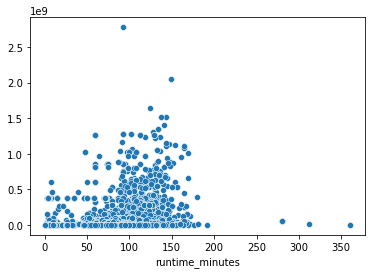

In [80]:
# runtime vs. gross scatter
sns.scatterplot(x=x, y=y)

In [169]:
# runtime vs. popularity test
ind_ttest(x, y1)

Ttest_indResult(statistic=173.57182816424387, pvalue=0.0)

<AxesSubplot:xlabel='runtime_minutes', ylabel='popularity'>

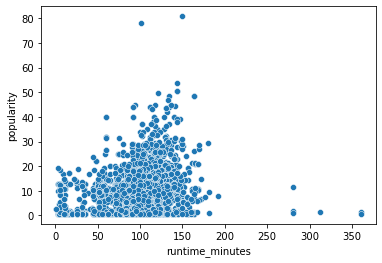

In [79]:
# runtime vs. popularity scatter
sns.scatterplot(x=x, y=y1)

In [170]:
# runtime vs. vote_average test
ind_ttest(x, y2)

Ttest_indResult(statistic=183.63134930805032, pvalue=0.0)

<AxesSubplot:xlabel='runtime_minutes', ylabel='vote_average'>

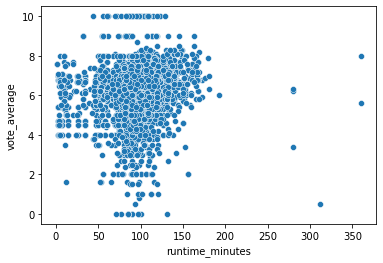

In [78]:
# runtime vs. vote_average scatter
sns.scatterplot(x=x, y=y2)

In [171]:
# runtime vs. domestic gross test
ind_ttest(x, y3)

Ttest_indResult(statistic=-36.47720637686222, pvalue=1.8787415821787119e-252)

In [ ]:
# runtime vs. domestic gross scatter
sns.scatterplot(x=x, y=y3)

In [172]:
# budget vs. gross test
ind_ttest(x1, y)

Ttest_indResult(statistic=-22.250526813161205, pvalue=3.327923363291706e-104)

<AxesSubplot:>

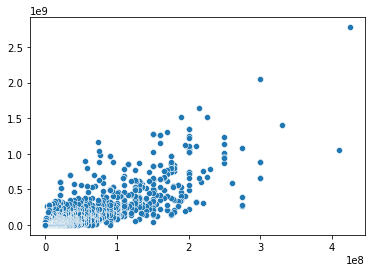

In [77]:
# budget vs. gross scatter
sns.scatterplot(x=x1, y=y)

In [173]:
# budget vs. popularity test
ind_ttest(x1, y1)

Ttest_indResult(statistic=45.93238593185758, pvalue=0.0)

<AxesSubplot:ylabel='popularity'>

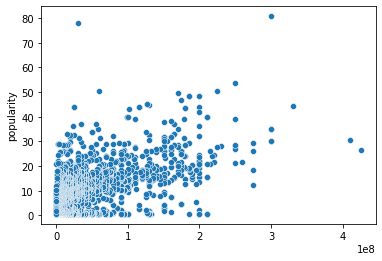

In [75]:
# budget vs. popularity scatter
sns.scatterplot(x=x1, y=y1)

In [174]:
# budget vs. vote_average test
# ?? getting same result for this as budget vs. popularity
ind_ttest(x1, y2)

Ttest_indResult(statistic=45.93238876822305, pvalue=0.0)

<AxesSubplot:ylabel='vote_average'>

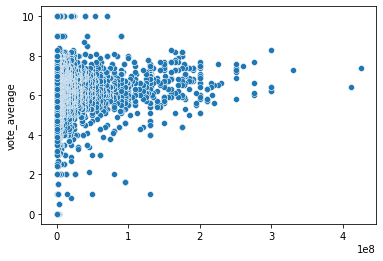

In [76]:
# budget vs. vote_average scatter
sns.scatterplot(x=x1, y=y2)

In [175]:
# budget vs. domestic gross
ind_ttest(x1, y3)

Ttest_indResult(statistic=-6.866107773251432, pvalue=7.180061040191765e-12)

In [ ]:
# budget vs. domestic gross scatter
sns.scatterplot(x=x1, y=y3)

In [43]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 0 to 4549
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_x               4088 non-null   int64  
 1   release_date_x     4088 non-null   object 
 2   primary_title      4088 non-null   object 
 3   production_budget  4088 non-null   object 
 4   domestic_gross     4088 non-null   object 
 5   worldwide_gross    4088 non-null   object 
 6   movie_id           4088 non-null   object 
 7   original_title_x   4088 non-null   object 
 8   start_year         4088 non-null   int64  
 9   runtime_minutes    4088 non-null   float64
 10  genres             4070 non-null   object 
 11  Unnamed: 0         4088 non-null   int64  
 12  genre_ids          4088 non-null   object 
 13  id_y               4088 non-null   int64  
 14  original_language  4088 non-null   object 
 15  original_title_y   4088 non-null   object 
 16  popularity         4088 

In [44]:
# defining the variables for runtime and budget linear regression

x = sm.add_constant(movie_basics_budget['runtime_minutes'].values.astype(int))
x1 = sm.add_constant(movie_basics_budget['production_budget'].values.astype(int))
y = movie_basics_budget['worldwide_gross'].values.astype(int)

In [45]:
# budget vs. worldwide gross regression

lin_reg_model = sm.OLS(y, x1).fit().summary()
lin_reg_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7056.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:47:26   Log-Likelihood:                -81945.
No. Observations:                4088   AIC:                         1.639e+05
Df Residuals:                    4086   BIC:                         1.639e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.512e+06   2.37e+06     -3.597      0.000   -1.32e+07   -3.87e+06
x1             3.3258      0.040     83.998      0.000       3.248       3.403
==============================================================================
Omnibus:                     2584.969   Durbin-Watson:                   0.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59935.054
Skew:                           2.618   Prob(JB):                         0.00
Kurtosis:                      21.012   Cond. No.                     7.36e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# runtime vs. worldwide gross regression

lin_reg_model_2 = sm.OLS(y, x).fit().summary()
lin_reg_model_2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     44.62
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           2.72e-11
Time:                        17:47:26   Log-Likelihood:                -83973.
No. Observations:                4088   AIC:                         1.680e+05
Df Residuals:                    4086   BIC:                         1.680e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.265e+07   1.02e+07      4.181      0.000    2.27e+07    6.27e+07
x1          6.854e+05   1.03e+05      6.680      0.000    4.84e+05    8.87e+05
==============================================================================
Omnibus:                     3249.916   Durbin-Watson:                   0.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78448.636
Skew:                           3.683   Prob(JB):                         0.00
Kurtosis:                      23.157   Cond. No.                         321.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## Looking at movie_budgets

In [48]:
zero_gross = movie_budgets.loc[movie_budgets['domestic_gross'] == 0]
zero_gross

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross


In [49]:
movie_budgets.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [50]:
movie_budgets.rename(columns={"movie":"primary_title"})

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [51]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [52]:
movie_budgets.describe(include='all')

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5782,5782,5782,5782
unique,NaN,2418,5698,509,5164,5356
top,NaN,"Dec 31, 2014",King Kong,"$20,000,000",$0,$0
freq,NaN,24,3,231,548,367
mean,50.372363,NaN,NaN,NaN,NaN,NaN
std,28.821076,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN
25%,25.000000,NaN,NaN,NaN,NaN,NaN
50%,50.000000,NaN,NaN,NaN,NaN,NaN
75%,75.000000,NaN,NaN,NaN,NaN,NaN


## Looking at tmdb_movies

In [53]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,primary_title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [54]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   primary_title      26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [55]:
tmdb_movies.describe(include='all')

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,primary_title,vote_average,vote_count
count,26517.00000,26517,26517.000000,26517,26517,26517.000000,26517,26517,26517.000000,26517.000000
unique,NaN,2477,NaN,76,24835,NaN,3433,24688,NaN,NaN
top,NaN,[99],NaN,en,Eden,NaN,2010-01-01,Eden,NaN,NaN
freq,NaN,3700,NaN,23291,7,NaN,269,7,NaN,NaN
mean,13258.00000,NaN,295050.153260,NaN,NaN,3.130912,NaN,NaN,5.991281,194.224837
std,7654.94288,NaN,153661.615648,NaN,NaN,4.355229,NaN,NaN,1.852946,960.961095
min,0.00000,NaN,27.000000,NaN,NaN,0.600000,NaN,NaN,0.000000,1.000000
25%,6629.00000,NaN,157851.000000,NaN,NaN,0.600000,NaN,NaN,5.000000,2.000000
50%,13258.00000,NaN,309581.000000,NaN,NaN,1.374000,NaN,NaN,6.000000,5.000000
75%,19887.00000,NaN,419542.000000,NaN,NaN,3.694000,NaN,NaN,7.000000,28.000000


## Looking at rt_reviews

In [56]:
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [57]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [58]:
rt_reviews.describe(include='all')

,id,review,rating,fresh,critic,top_critic,publisher,date
count,54432.000000,48869,40915,54432,51710,54432.000000,54123,54432
unique,NaN,48682,186,2,3496,NaN,1281,5963
top,NaN,Parental Content Review,3/5,fresh,Emanuel Levy,NaN,eFilmCritic.com,"January 1, 2000"
freq,NaN,24,4327,33035,595,NaN,673,4303
mean,1045.706882,NaN,NaN,NaN,NaN,0.240594,NaN,NaN
std,586.657046,NaN,NaN,NaN,NaN,0.427448,NaN,NaN
min,3.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,542.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
50%,1083.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
75%,1541.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


## Looking at rt_movie_info

In [59]:
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [60]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [61]:
rt_movie_info.describe(include='all')

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
count,1560.000000,1498,1557,1552,1361,1111,1201,1201,340,340,1530,494
unique,NaN,1497,6,299,1125,1069,1025,717,1,336,142,200
top,NaN,A group of air crash survivors are stranded in...,R,Drama,Steven Spielberg,Woody Allen,"Jan 1, 1987","Jun 1, 2004",$,"200,000",90 minutes,Universal Pictures
freq,NaN,2,521,151,10,4,8,11,340,2,72,35
mean,1007.303846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,579.164527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,504.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1007.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1503.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Looking at movie_gross

In [62]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [63]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [64]:
movie_gross.describe(include='all')

,title,studio,domestic_gross,foreign_gross,year
count,3387,3382,3.359000e+03,2037,3387.000000
unique,3386,257,NaN,1204,NaN
top,Bluebeard,IFC,NaN,1200000,NaN
freq,2,166,NaN,23,NaN
mean,NaN,NaN,2.874585e+07,NaN,2013.958075
std,NaN,NaN,6.698250e+07,NaN,2.478141
min,NaN,NaN,1.000000e+02,NaN,2010.000000
25%,NaN,NaN,1.200000e+05,NaN,2012.000000
50%,NaN,NaN,1.400000e+06,NaN,2014.000000
75%,NaN,NaN,2.790000e+07,NaN,2016.000000


In [65]:
groupby = movie_gross.groupby('studio').mean()
groupby.sort_values('domestic_gross', ascending=False)

,domestic_gross,year
studio,,
BV,1.737644e+08,2013.688679
P/DW,1.682900e+08,2010.900000
WB (NL),8.879333e+07,2014.311111
Uni.,8.777138e+07,2014.163265
WB,8.691461e+07,2013.864286
...,...,...
Shout!,2.800000e+03,2014.000000
Synergetic,2.400000e+03,2018.000000
DR,8.000000e+02,2014.000000


In [66]:
lin_reg_model_3 = sm.OLS(y, x1).fit().summary()
